In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"


In [2]:
!kaggle datasets download -d shweta2407/flickr8k-imageswithcaptions

100% 1.04G/1.04G [00:34<00:00, 35.6MB/s]
100% 1.04G/1.04G [00:34<00:00, 32.4MB/s]


In [3]:
!unzip flickr8k-imageswithcaptions.zip

Streaming output truncated to the last 5000 lines.
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/2846843520_b0e6211478.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/2847514745_9a35493023.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/2847615962_c330bded6e.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/2847859796_4d9cb0d31f.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/2848266893_9693c66275.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/2848571082_26454cb981.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/2848895544_6d06210e9d.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/2848977044_446a31d86e.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/2849194983_2968c72832.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/2850719435_221f15e951.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/2851198725_37b6027625.jpg  
  inflating: Flickr8k_Dataset/Flicker8k_Dataset/2851304910_b5721199bc.jpg  
  inflating: Flickr8k_Dataset/Flicker

In [4]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model
from tensorflow import keras
import matplotlib.pyplot as plt
import string
from keras.applications.resnet50 import ResNet50
from pickle import dump
from pickle import load
from IPython.display import Image
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
import numpy as np
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from keras.layers.merge import add, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [5]:
image_path = 'Flickr8k_Dataset/Flicker8k_Dataset'
caption_path = 'Flickr8k_text/Flickr8k.token.txt'

In [6]:
def load_captions(path):
    captions_dict = {}    
    for caption in open(path):
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text
        
    return captions_dict

captions_dict = load_captions(caption_path)

In [7]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [8]:
new_captions_dict = {}
table = str.maketrans('', '', string.punctuation)

for caption_id, caption_text in captions_dict.items():
    caption_text = caption_text.split()
    caption_text = [token.lower() for token in caption_text]
    caption_text = [token.translate(table) for token in caption_text]
    caption_text = [token for token in caption_text if len(token)>1]
    # store cleaned captions
    new_captions_dict[caption_id] = 'startseq ' + ' '.join(caption_text) + ' endseq'

In [9]:
caption_images_list = []
image_index = list(new_captions_dict.keys())
caption_images_list = [ image.split('.')[0] for image in os.listdir(image_path) if image.split('.')[0] in image_index ]

In [10]:
train_validate_images = caption_images_list[0:8081] 
test_images = caption_images_list[8081:8091]
test_images

['2480850054_de3433b54a',
 '3638374272_444f5e0457',
 '2694178830_116be6a6a9',
 '3293018193_e4e0c8db7c',
 '2938072630_d641b63e4d',
 '3288174272_2daa06d360',
 '2629295654_59ea1472a1',
 '3718305988_fe2c91fd44',
 '3722507770_0d6cb7420e',
 '2737759676_4bc9be2daf']

In [12]:
def extract_features(directory, image_keys):
    model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
    print(model.summary())
    features = dict()
    
    for name in image_keys:
        filename = directory + '/' + name + '.jpg'
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
         

    return features

In [13]:
train_validate_features1 = extract_features(image_path, train_validate_images)

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [14]:
print("{} : {}".format(list(train_validate_features1.keys())[0], train_validate_features1[list(train_validate_features1.keys())[0]] ))

1542033433_5453d4c466 : [[0.10583607 0.22071038 0.00935664 ... 0.42497116 0.32074457 0.08477942]]


In [15]:
len(train_validate_features1)

8081

In [16]:
dump(train_validate_features1, open('./train_validate_features1.pkl', 'wb'))
# train_validate_features1 = load(open('./train_validate_features1.pkl', 'rb'))

In [17]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():
    if image in train_validate_images and image in list(train_validate_features1.keys()):
        train_validate_image_caption.update({image : caption})

len(train_validate_image_caption)

8081

startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq


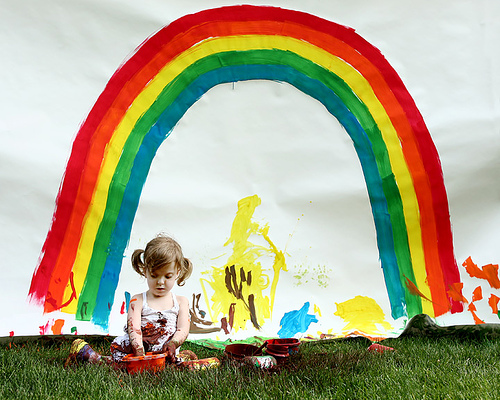

In [18]:
print(list(train_validate_image_caption.values())[2])
Image(image_path+'/'+list(train_validate_image_caption.keys())[2]+'.jpg')

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(train_validate_image_caption.values()))
vocab_len = len(tokenizer.word_index) + 1
max_len = max(len(train_validate_image_caption[image].split()) for image in train_validate_image_caption)

print("vocab_len ", vocab_len)
print("max_len ", max_len)

def prepare_data(image_keys):
    # x1 will store  image feature, x2 will store one sequence and y will store the next sequence
    x1, x2, y = [], [], []
    for image in image_keys:
      caption = train_validate_image_caption[image]
      caption = caption.split()
      seq = tokenizer.texts_to_sequences([caption])[0]
      # print(seq)
      length = len(seq)

      for i in range(1, length):
        x2_seq, y_seq = seq[:i] , seq[i] 
        # print(y_seq) 
        x2_seq = pad_sequences([x2_seq], maxlen = max_len)[0]
        y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]
        # print(y_seq) 
        x1.append( train_validate_features1[image][0] )
        x2.append(x2_seq)
        y.append(y_seq)
                
    return np.array(x1), np.array(x2), np.array(y)

vocab_len  4484
max_len  30


In [20]:
train_x1, train_x2, train_y = prepare_data( train_validate_images[0:7081] )
validate_x1, validate_x2, validate_y = prepare_data( train_validate_images[7081:8081] )

In [21]:
embedding_size = 128
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(Dropout(0.5))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [22]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_len, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256,return_sequences=True))
language_model.add(Dropout(0.5))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 128)           573952    
_________________________________________________________________
lstm (LSTM)                  (None, 30, 256)           394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 128)           32896     
Total params: 1,001,088
Trainable params: 1,001,088
Non-trainable params: 0
_________________________________________________________________


In [42]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, dropout=0.5, recurrent_dropout=0.5,return_sequences=True)(conca)
x = LSTM(512, dropout=0.5, recurrent_dropout=0.5,return_sequences=False)(x)
x = Dense(vocab_len)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 30)]         0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 128)      573952      embedding_input[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          262272      dense_input[0][0]                
____________________________________________________________________________________________

In [49]:
import tensorflow
filepath = './image_captioning.h5'
def scheduler(epoch, lr):
  if epoch < 15:
    return lr
  if epoch < 30 and epoch > 15:
    return lr/100 
  else:
    return lr/10000
callbacks = [ ModelCheckpoint(filepath= filepath, verbose = 2,save_best_only=True, monitor='val_loss', mode='min'),tensorflow.keras.callbacks.LearningRateScheduler(scheduler) ]

In [50]:
print("shape of train_x1 ", train_x1.shape)
print("shape of train_x2 ", train_x2.shape)
print("shape of train_y ", train_y.shape)
print()
print("shape of validate_x1 ", validate_x1.shape)
print("shape of validate_x2 ", validate_x2.shape)
print("shape of validate_y ", validate_y.shape)

shape of train_x1  (72385, 2048)
shape of train_x2  (72385, 30)
shape of train_y  (72385, 4484)

shape of validate_x1  (10147, 2048)
shape of validate_x2  (10147, 30)
shape of validate_y  (10147, 4484)


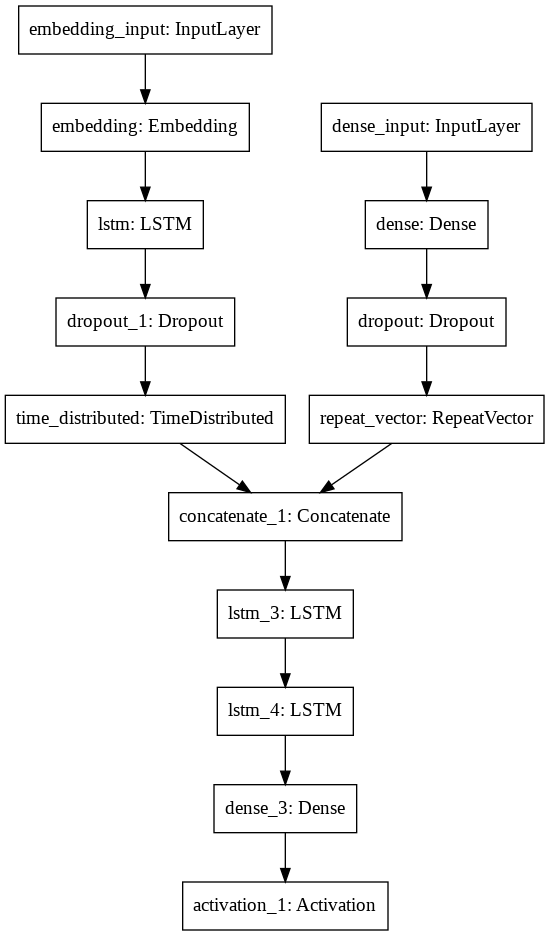

In [51]:
plot_model(model)

In [52]:
BATCH_SIZE = 512
EPOCHS = 50
history = model.fit([train_x1, train_x2],  
                    train_y,              
                    verbose = 1,            
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = callbacks, 
                    validation_data=([validate_x1, validate_x2], validate_y)) 

Epoch 1/100
142/142 [==============================] - 74s 523ms/step - loss: 5.1264 - val_loss: 4.6409

Epoch 00001: val_loss improved from inf to 4.64089, saving model to ./image_captioning.h5
Epoch 2/100
142/142 [==============================] - 71s 501ms/step - loss: 4.4753 - val_loss: 4.5186

Epoch 00002: val_loss improved from 4.64089 to 4.51864, saving model to ./image_captioning.h5
Epoch 3/100
142/142 [==============================] - 71s 502ms/step - loss: 4.3058 - val_loss: 4.4845

Epoch 00003: val_loss improved from 4.51864 to 4.48454, saving model to ./image_captioning.h5
Epoch 4/100
142/142 [==============================] - 72s 504ms/step - loss: 4.2010 - val_loss: 4.4905

Epoch 00004: val_loss did not improve from 4.48454
Epoch 5/100
142/142 [==============================] - 72s 510ms/step - loss: 4.1243 - val_loss: 4.4787

Epoch 00005: val_loss improved from 4.48454 to 4.47875, saving model to ./image_captioning.h5
Epoch 6/100
142/142 [==============================]

KeyboardInterrupt: ignored

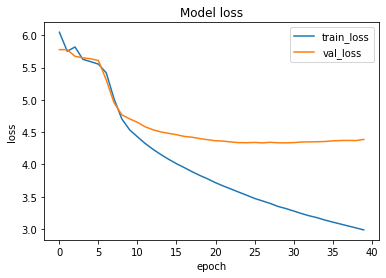

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

In [29]:
def extract_feat_single(filename):
    model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None

In [30]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

## Testing

In [58]:
model = load_model('./image_captioning.h5')
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in train_validate_images])
max_length = max_len

Predicted caption ->   man in red shirt is standing on the camera 


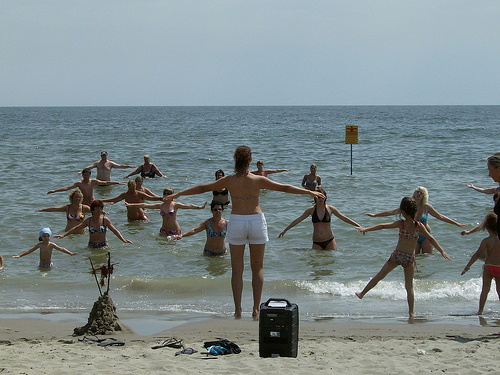

In [60]:
photo = extract_feat_single('Flickr8k_Dataset/Flicker8k_Dataset/554526471_a31f8b74ef.jpg')  

in_text = 'startseq'
for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    yhat = model.predict([photo,sequence], verbose=0)
    yhat = np.argmax(yhat)
    word = word_for_id(yhat, tokenizer)
    if word is None:
        break
    in_text += ' ' + word
    if word == 'endseq':
        break
in_text = in_text.replace('startseq','') 
in_text = in_text.replace('endseq','') 
print("Predicted caption -> ", in_text)
Image('Flickr8k_Dataset/Flicker8k_Dataset/554526471_a31f8b74ef.jpg')